In [77]:
import numpy
import re
import os
import matplotlib.pyplot as pyplot
%matplotlib inline

from collections import namedtuple
from collections import defaultdict

ExpStats = namedtuple('Stats', ['train_X_Y', 'train_X', 'train_Y', 'train_Y_X',
                             'test_X_Y', 'test_X', 'test_Y', 'test_Y_X',
                            'acc_mpe', 'ham_mpe', 'ext_mpe',
                            'acc_marg', 'ham_marg', 'ext_marg'])

USE_NOTEBOOK = True

In [8]:
def parse_ll_from_log(log_str, ll_prefix='Train:', n_folds=5, newline='\n'):
    
    p_X_Y_lls = []
    p_X_lls = []
    p_Y_lls = []
    p_Y_X_lls = []
    
    lines = log_str.split(newline)
    for line in lines:
        if ll_prefix in line:
            stats = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            assert len(stats) == 4
            
            p_X_Y_lls.append(float(stats[0]))
            p_X_lls.append(float(stats[1]))
            p_Y_lls.append(float(stats[2]))
            p_Y_X_lls.append(float(stats[3]))
            
    assert len(p_X_Y_lls) == 5
    assert len(p_X_lls) == 5
    assert len(p_Y_lls) == 5
    assert len(p_Y_X_lls) == 5
    
    return numpy.array(p_X_Y_lls), numpy.array(p_X_lls), numpy.array(p_Y_lls), numpy.array(p_Y_X_lls)

In [9]:
if USE_NOTEBOOK:
    file_path = '/home/valerio/Downloads/newcsn/l0.6ts0/arts.log'
    with open(file_path, 'r') as f:
        log_contents = f.read()
        
    train_X_Y, train_X, train_Y, train_Y_X = parse_ll_from_log(log_contents, 'Train:', 5)
    print(train_X_Y)
    print(train_X)
    print(train_Y)
    print(train_Y_X)
    
    test_X_Y, test_X, test_Y, test_Y_X = parse_ll_from_log(log_contents, 'Test:', 5)
    print(test_X_Y)
    print(test_X)
    print(test_Y)
    print(test_Y_X)

[-26.85714962 -26.65849524 -26.85600933 -26.61176421 -26.62904252]
[-23.1369752  -22.76179664 -23.14640876 -22.94594425 -22.86228867]
[-4.62170623 -4.71037673 -4.59397574 -4.5913171  -4.636254  ]
[-3.72017441 -3.8966986  -3.70960057 -3.66581996 -3.76675385]
[-28.42492085 -30.35267217 -28.54861664 -29.68318685 -30.37089305]
[-23.97000886 -25.86773568 -24.03973844 -25.0265959  -25.76909386]
[-4.59778773 -4.65549616 -4.68432662 -4.64594702 -4.67789959]
[-4.45491199 -4.48493649 -4.5088782  -4.65659095 -4.60179918]


In [10]:
def parse_scores_from_log(log_str, stat_prefix='Accuracy', n_folds=5, newline='\n'):
    scores = []
    lines = log_str.split(newline)
    for line in lines:
        if stat_prefix in line:
            stats = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            if len(stats) == n_folds:
                scores.extend([float(s) for s in stats])
                
    assert len(scores) == n_folds * 2
    return numpy.array(scores[:n_folds]), numpy.array(scores[n_folds:])
            

In [13]:
if USE_NOTEBOOK:
    file_path = '/home/valerio/Downloads/newcsn/l0.6ts0/arts.log'
    with open(file_path, 'r') as f:
        log_contents = f.read()
        
    acc_mpe, acc_marg = parse_scores_from_log(log_contents, 'Accuracy', 5)
    print(acc_mpe)
    print(acc_marg)
    
    ham_mpe, ham_marg = parse_scores_from_log(log_contents, 'Hamming Score', 5)
    print(ham_mpe)
    print(ham_marg)
    
    ext_mpe, ext_marg = parse_scores_from_log(log_contents, 'Exact match', 5)
    print(ext_mpe)
    print(ext_marg)

[ 0.385391  0.411938  0.418159  0.414396  0.394681]
[ 0.386499  0.406131  0.424784  0.414603  0.402825]
[ 0.934836  0.937953  0.936771  0.936754  0.935392]
[ 0.936402  0.938133  0.938878  0.938066  0.937217]
[ 0.303738  0.315965  0.329325  0.332219  0.301471]
[ 0.293057  0.303941  0.328657  0.323529  0.299465]


In [15]:

def parse_stats_from_log(log_path, n_folds=5, newline='\n'):
    """
    From a string representing a log file content,
    Extract these information:
    For each fold:
        - train log likelihoods:
            - p(X, Y)
            - p(X)
            - p(Y)
            - p(Y|X)
        - test log likelihoods:
            - p(X, Y)
            - p(X)
            - p(Y)
            - p(Y|X)
        - MPE scores:
            - accuracy
            - hamming loss
            - exact match
        - MARG scores:
            - accuracy
            - hamming loss
            - exact match
    they are put into a ExpStats namedtuple
    """
    log_str = None
    with open(log_path, 'r') as log_file:
        log_str = log_file.read()
        
    train_X_Y, train_X, train_Y, train_Y_X = parse_ll_from_log(log_str, 'Train:', n_folds=n_folds, newline=newline)
    test_X_Y, test_X, test_Y, test_Y_X = parse_ll_from_log(log_str, 'Test:', n_folds=n_folds, newline=newline)
    
    acc_mpe, acc_marg = parse_scores_from_log(log_str, 'Accuracy', n_folds=n_folds, newline=newline)
    ham_mpe, ham_marg = parse_scores_from_log(log_str, 'Hamming Score', n_folds=n_folds, newline=newline)
    ext_mpe, ext_marg = parse_scores_from_log(log_str, 'Exact match', n_folds=n_folds, newline=newline)
    
    return ExpStats(train_X_Y, train_X, train_Y, train_Y_X, 
                   test_X_Y, test_X, test_Y, test_Y_X,
                   acc_mpe, ham_mpe, ext_mpe,
                   acc_marg, ham_marg, ext_marg)

In [23]:
def print_stats(exp_stats):
    print('train log p(X,Y):\t', exp_stats.train_X_Y)
    print('train log p(X):\t', exp_stats.train_X)
    print('train log p(Y):\t', exp_stats.train_Y)
    print('train log p(Y|X):\t', exp_stats.train_Y_X)

    print('test log p(X,Y):\t', exp_stats.test_X_Y)
    print('test log p(X):\t', exp_stats.test_X)
    print('test log p(Y):\t', exp_stats.test_Y)
    print('test log p(Y|X):\t', exp_stats.test_Y_X)
    
    print('accuracy MPE:\t', exp_stats.acc_mpe)
    print('hamming MPE:\t', exp_stats.ham_mpe)
    print('extact match MPE:\t', exp_stats.ext_mpe)
    
    print('accuracy Marg:\t', exp_stats.acc_marg)
    print('hamming Marg:\t', exp_stats.ham_marg)
    print('extact match marg:\t', exp_stats.ext_marg)

In [24]:
if USE_NOTEBOOK:
    file_path = '/home/valerio/Downloads/newcsn/l0.6ts0/arts.log'
    exp_stats = parse_stats_from_log(file_path)
    print_stats(exp_stats)

train log p(X,Y):	 [-26.85714962 -26.65849524 -26.85600933 -26.61176421 -26.62904252]
train log p(X):	 [-23.1369752  -22.76179664 -23.14640876 -22.94594425 -22.86228867]
train log p(Y):	 [-4.62170623 -4.71037673 -4.59397574 -4.5913171  -4.636254  ]
train log p(Y|X):	 [-3.72017441 -3.8966986  -3.70960057 -3.66581996 -3.76675385]
test log p(X,Y):	 [-28.42492085 -30.35267217 -28.54861664 -29.68318685 -30.37089305]
test log p(X):	 [-23.97000886 -25.86773568 -24.03973844 -25.0265959  -25.76909386]
test log p(Y):	 [-4.59778773 -4.65549616 -4.68432662 -4.64594702 -4.67789959]
test log p(Y|X):	 [-4.45491199 -4.48493649 -4.5088782  -4.65659095 -4.60179918]
accuracy MPE:	 [ 0.385391  0.411938  0.418159  0.414396  0.394681]
hamming MPE:	 [ 0.934836  0.937953  0.936771  0.936754  0.935392]
extact match MPE:	 [ 0.303738  0.315965  0.329325  0.332219  0.301471]
accuracy Marg:	 [ 0.386499  0.406131  0.424784  0.414603  0.402825]
hamming Marg:	 [ 0.936402  0.938133  0.938878  0.938066  0.937217]
extac

In [43]:
DATASETS = [
    #'arts', 
            'birds', 'business', 'cal', 'emotions', 'flags', 'health', 'human', 'plant', 'scene', 'yeast']

def parse_stats_for_exp(exp_dir, datasets=DATASETS, n_folds=5, newline='\n'):
    """
    Parse the stats for each dataset log file in a dir
    """
    stats_dict = {}
    
    for d in datasets:
        print('\n\tconsidering dataset {}'.format(d))
        data_path = os.path.join(exp_dir, '{}.log'.format(d))
        exp_stats = parse_stats_from_log(data_path, n_folds=n_folds, newline=newline)
        stats_dict[d] = exp_stats
        
    return stats_dict

In [29]:
if USE_NOTEBOOK:
    exp_dir = '/home/valerio/Downloads/newcsn/l0.6ts0'
    
    stats = parse_stats_for_exp(exp_dir)
    for k, v in stats.items():
        print(k)
        print_stats(v)

scene
train log p(X,Y):	 [-100.11225567  -99.78257184 -100.15591744 -100.2068322  -100.13090683]
train log p(X):	 [-98.54349561 -98.23735346 -98.5940657  -98.6457224  -98.56100839]
train log p(Y):	 [-2.19082433 -2.17127021 -2.19394491 -2.18800314 -2.18144029]
train log p(Y|X):	 [-1.56876006 -1.54521838 -1.56185175 -1.5611098  -1.56989844]
test log p(X,Y):	 [-103.1361335  -104.55640006 -102.8798233  -102.4054884  -102.72650493]
test log p(X):	 [-101.06684144 -102.20336878 -100.22905807 -100.18544097 -100.30304743]
test log p(Y):	 [-2.16581192 -2.25711744 -2.1538311  -2.17857825 -2.20371779]
test log p(Y|X):	 [-2.06929206 -2.35303128 -2.65076522 -2.22004743 -2.4234575 ]
accuracy MPE:	 [ 0.661826  0.664592  0.666321  0.660083  0.635764]
hamming MPE:	 [ 0.881743  0.882089  0.883126  0.880804  0.872222]
extact match MPE:	 [ 0.582988  0.580913  0.60166   0.5842    0.554167]
accuracy Marg:	 [ 0.665629  0.673237  0.672545  0.675329  0.631597]
hamming Marg:	 [ 0.883817  0.886584  0.885201  0.88

In [50]:
TREE_STRUCTURES = [0, 1, 2, 3]
CL_CSN = ['0.6', '1.0']
Y_LEAVES = [False, True]

def parse_stats_for_models_exps(exp_dir, 
                                tree_structures=TREE_STRUCTURES,
                                splits=CL_CSN,
                                leaves=Y_LEAVES,
                                datasets=DATASETS, 
                                n_folds=5, 
                                newline='\n'):
    
    dataset_assoc = defaultdict(dict)
    model_assoc = {}
    
    for ts in tree_structures:
        for s in splits:
            exp_prefix = 'l{}ts{}'.format(s, ts)
            for l in leaves:
                if l:
                    exp_prefix += 'l'
                print('\n\nConsidering exp: {}'.format(exp_prefix))
                exp_path = os.path.join(exp_dir, exp_prefix)
                
                stats_dict = parse_stats_for_exp(exp_path, datasets=datasets, n_folds=n_folds, newline=newline)
                
                # for k, v in stats_dict.items():
                #    print('\t{}'.format(k))
                #    print_stats(v)
                
                model_assoc[exp_prefix] = stats_dict
                
                for dataset, v in stats_dict.items():
                    dataset_assoc[dataset][exp_prefix] = v
                    
    return dataset_assoc, model_assoc

In [51]:
if USE_NOTEBOOK:
    exp_dir = '/home/valerio/Downloads/newcsn'
    dataset_assoc, model_assoc = parse_stats_for_models_exps(exp_dir, datasets=DATASETS)
    




Considering exp: l0.6ts0

	considering dataset birds

	considering dataset business

	considering dataset cal

	considering dataset emotions

	considering dataset flags

	considering dataset health

	considering dataset human

	considering dataset plant

	considering dataset scene

	considering dataset yeast


Considering exp: l0.6ts0l

	considering dataset birds

	considering dataset business

	considering dataset cal

	considering dataset emotions

	considering dataset flags

	considering dataset health

	considering dataset human

	considering dataset plant

	considering dataset scene

	considering dataset yeast


Considering exp: l1.0ts0

	considering dataset birds

	considering dataset business

	considering dataset cal

	considering dataset emotions

	considering dataset flags

	considering dataset health

	considering dataset human

	considering dataset plant

	considering dataset scene

	considering dataset yeast


Considering exp: l1.0ts0l

	considering dataset birds

	consi

In [93]:
def tiling_sizes(n_images, n_cols=None):

    n_rows = None

    if n_cols is None:
        n_rows = int(numpy.sqrt(n_images))
        n_cols = n_rows
    else:
        n_rows = max(n_images // n_cols, 1)

    rem_tiles = n_images - n_rows * n_cols

    if rem_tiles > 0:
        n_rem_rows, n_rem_cols = tiling_sizes(rem_tiles, n_cols)
        return n_rows + n_rem_rows, n_cols

    return n_rows, n_cols

In [131]:
def plot_model_boxplot_stat(model_assoc, 
                            stat_names=['train_X_Y', 'test_X_Y'],
                            model_names=None,
                            n_rows=1):
    
    n_models = len(model_assoc)
    n_stats = len(stat_names)
    
    labels = list(k for k in model_assoc)
        
    if n_rows > 1:
        n_cols = int(numpy.ceil(n_stats / n_rows))
    elif n_rows == 1:
        n_cols = n_stats
        
    print('Plotting into {} rows and {} cols'.format(n_rows, n_cols))
        
    fig, axes = pyplot.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 12))

    if model_names is None:
        model_names = [k for k in model_assoc]
    
    for k in range(n_stats):
        print('Considering stat {}'.format(stat_names[k]))
        data = []
        # for model, stats in model_assoc.items():
        for model in model_names:
            stats = model_assoc[model]
            data.append(getattr(stats, stat_names[k]))
        data = numpy.array(data).T

    
        i = k // n_cols
        j = k - i * n_cols
        print('i j', k, i, j)
        # for i in range(n_models):
        ax = None
        if n_rows == 1:
            ax = axes[k]
        else:
            ax = axes[i, j]
        ax.boxplot(data, 
                        #labels=labels,
                   showmeans=True
                       )
        ax.set_title(stat_names[k])
        ax.set_xticklabels(model_names, rotation=90)
        
    pyplot.show()



Considering exp: l0.6ts0

	considering dataset birds

	considering dataset business

	considering dataset cal

	considering dataset emotions

	considering dataset flags

	considering dataset health

	considering dataset human

	considering dataset plant

	considering dataset scene

	considering dataset yeast


Considering exp: l0.6ts0l

	considering dataset birds

	considering dataset business

	considering dataset cal

	considering dataset emotions

	considering dataset flags

	considering dataset health

	considering dataset human

	considering dataset plant

	considering dataset scene

	considering dataset yeast


Considering exp: l1.0ts0

	considering dataset birds

	considering dataset business

	considering dataset cal

	considering dataset emotions

	considering dataset flags

	considering dataset health

	considering dataset human

	considering dataset plant

	considering dataset scene

	considering dataset yeast


Considering exp: l1.0ts0l

	considering dataset birds

	consi

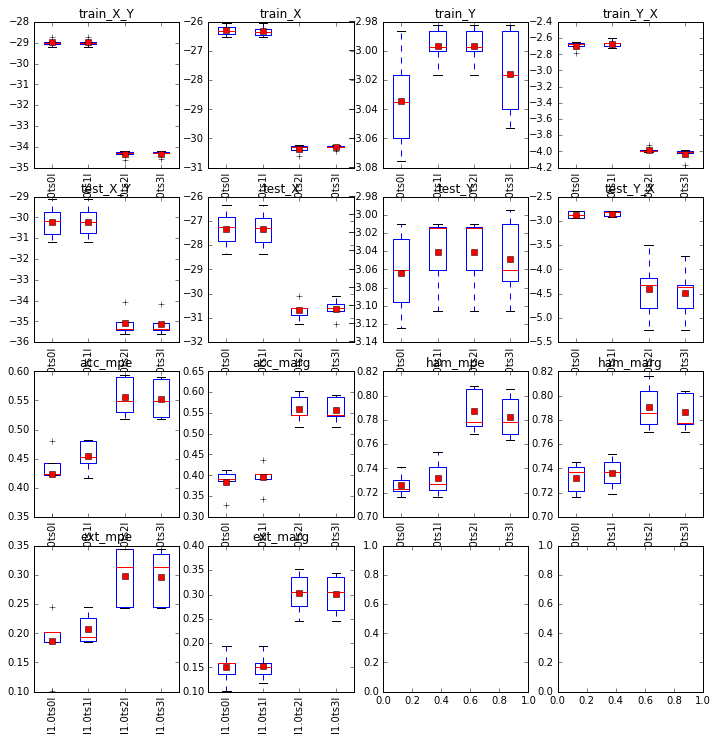

In [132]:
if USE_NOTEBOOK:
    exp_dir = '/home/valerio/Downloads/newcsn'
    dataset_assoc, model_assoc = parse_stats_for_models_exps(exp_dir, datasets=DATASETS)
    
    
    plot_model_boxplot_stat(dataset_assoc['emotions'],
                            stat_names=['train_X_Y', 'train_X', 'train_Y', 'train_Y_X', 
                                        'test_X_Y', 'test_X', 'test_Y', 'test_Y_X',
                                       'acc_mpe', 'acc_marg', 
                                        
                                        'ham_mpe', 'ham_marg',
                                       'ext_mpe', 'ext_marg'],
                            n_rows=4,
                            model_names=['l1.0ts0l', 'l1.0ts1l', 'l1.0ts2l', 'l1.0ts3l'])

In [133]:
print(dataset_assoc['human']['l1.0ts1l'].ham_mpe.mean())
print(dataset_assoc['human']['l1.0ts1l'].ham_marg.mean())
print(dataset_assoc['human']['l1.0ts2l'].ham_mpe.mean())
print(dataset_assoc['human']['l1.0ts2l'].ham_marg.mean())
print(dataset_assoc['human']['l1.0ts1l'].ext_mpe.mean())
print(dataset_assoc['human']['l1.0ts1l'].ext_marg.mean())
print(dataset_assoc['human']['l1.0ts2l'].ext_mpe.mean())
print(dataset_assoc['human']['l1.0ts2l'].ext_marg.mean())

0.8931326
0.8930862
0.8948844
0.894999
